<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=177012832" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv
/kaggle/input/flood-prediction-factors/flood.csv


In [4]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *
!pip install fastkaggle
!pip install optuna
!pip install optuna_distributed

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.0 MB/s eta 0:00:00


In [5]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

from fastkaggle import setup_comp

import optuna

In [6]:
!ls /kaggle/input/playground-series-s4e5

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


sample_submission.csv  test.csv  train.csv


In [7]:
#set_seed(42)

In [8]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [9]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [10]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [11]:
train_df.shape,original_df.shape

((1117957, 21), (50000, 21))

In [12]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape

(1167957, 21)

## Dataset Subset

Since the dataset is large and takes a while to train, we can use a subset of the data for quick experimentation

### Using random subset

Using a random subset results in better and faster training

In [13]:
#train_subset = train_df.sample(n=50000,replace=False)
#test_subset = test_df.sample(n=30000,replace=False)

## Using Full Dataset

In [14]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')

In [15]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [16]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [17]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [18]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Random Forest Baseline

We initially use a random forest as a baseline since it is a really simple model that doesnt break easily with small changes in the hyperparameters etc. 

We can also easily use this for explanability with features such as feature importance.

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

# Neural Network Baseline

SuggestedLRs(slide=0.009120108559727669, valley=0.0005754399462603033)

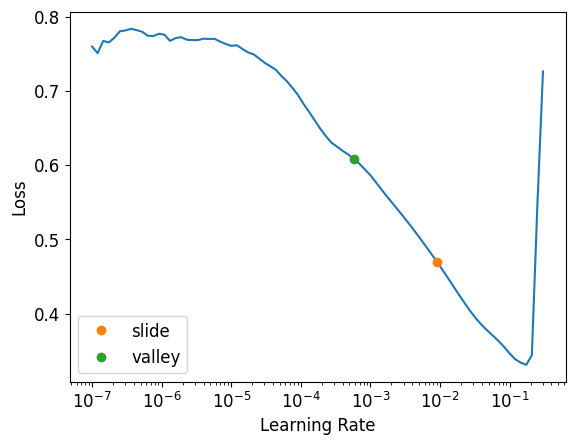

In [19]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [20]:
%%time
learn.fit_one_cycle(12,0.02)

epoch,train_loss,valid_loss,r2_score,time
0,0.000689,0.000427,0.836291,04:35
1,0.000592,0.000876,0.663735,04:03
2,0.000618,0.000424,0.837501,04:28
3,0.000607,0.000545,0.790729,04:37
4,0.000504,0.000561,0.784604,04:39
5,0.000511,0.000433,0.834008,04:42
6,0.000500,0.000411,0.842191,04:43
7,0.000508,0.000397,0.847681,04:47
8,0.000478,0.000387,0.851572,04:45
9,0.000463,0.000379,0.854746,04:49


CPU times: user 1h 50min 42s, sys: 24.2 s, total: 1h 51min 6s
Wall time: 55min 54s


In [21]:
dl = learn.dls.test_dl(test_df)

In [22]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 5min 46s, sys: 1.21 s, total: 5min 47s
Wall time: 2min 54s


In [23]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


models


In [24]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [25]:
r2_score(y_test,nn_preds_x)

0.8561906276638185

# Neural Network Ensemble

In [26]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(6, 0.02)
    return learn.get_preds(dl=dl)[0]

In [27]:
learns = [ensemble() for _ in range(5)]

ValueError: Exception occured in `Recorder` when calling event `after_validate`:
	continuous format is not supported

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
nn_preds_x.shape,ens_preds.shape

In [ ]:
r2_score(y_test,nn_preds_x)

In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['FloodProbability'] = target_preds

In [ ]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
!ls

# Optimize Params with Optuna

In [28]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score


study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=150)
print(study_catboost.best_params)

[I 2024-05-11 09:05:31,141] A new study created in memory with name: no-name-290accfc-9373-4267-9145-73b4c2f0b3c1
[I 2024-05-11 09:06:02,687] Trial 0 finished with value: 0.5614503220776348 and parameters: {'learning_rate': 0.024110353646960795, 'depth': 5, 'random_strength': 2}. Best is trial 0 with value: 0.5614503220776348.
[I 2024-05-11 09:06:38,978] Trial 1 finished with value: 0.4626567728734826 and parameters: {'learning_rate': 0.013795029614837953, 'depth': 6, 'random_strength': 1}. Best is trial 1 with value: 0.4626567728734826.
[I 2024-05-11 09:07:09,258] Trial 2 finished with value: 0.691108404524462 and parameters: {'learning_rate': 0.04106715322942578, 'depth': 5, 'random_strength': 5}. Best is trial 1 with value: 0.4626567728734826.
[I 2024-05-11 09:07:38,827] Trial 3 finished with value: 0.2860936957572453 and parameters: {'learning_rate': 0.010129042161435873, 'depth': 4, 'random_strength': 5}. Best is trial 3 with value: 0.2860936957572453.
[I 2024-05-11 09:08:03,213] 

{'learning_rate': 0.01000456241465664, 'depth': 1, 'random_strength': 10}


In [29]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150)
print(study_lgbm.best_params)

[I 2024-05-11 09:59:08,533] A new study created in memory with name: no-name-82bbc1ad-721c-4e5c-8d96-4ca7aabb1b75


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.294949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-11 09:59:33,981] Trial 0 finished with value: 0.8319698005770191 and parameters: {'num_leaves': 20, 'learning_rate': 0.18352149194865522, 'n_estimators': 150}. Best is trial 0 with value: 0.8319698005770191.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.264937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-11 10:00:01,138] Trial 1 finished with value: 0.8245092915714511 and parameters: {'num_leaves': 46, 'learning_rate': 0.22716774015271818, 'n_estimators': 165}. Best is trial 1 with value: 0.8245092915714511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.265318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-11 10:00:28,047] Trial 2 finished with value: 0.8278424202705192 and parameters: {'num_leaves': 37, 'learning_rate': 0.1288196234860299, 'n_estimators': 132}. Best is trial 1 with value: 0.8245092915714511.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.243371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-11 10:00:47,317] Trial 3 finished with value: 0.7819056011074499 and parameters: {'num_leaves': 20, 'learning_rate': 0.11483059626022993, 'n_estimators': 106}. Best is trial 3 with value: 0.7819056011074499.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.268388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[I 2024-05-11 10:01:19,892] Trial 4 finished with value: 0.832908714072796 and parameters: {'num_leaves': 40, 'learning_rate': 0.13883193349139092, 'n_estimators': 161}. Best is trial 3 with value: 0.7819056011074499.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.260827 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 368
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


[W 2024-05-11 10:01:50,287] Trial 5 failed with parameters: {'num_leaves': 46, 'learning_rate': 0.051420891382126355, 'n_estimators': 160} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<timed exec>", line 8, in objective_lgbm
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 1092, in fit
    super().fit(
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/sklearn.py", line 885, in fit
    self._Booster = train(
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/engine.py", line 276, in train
    booster.update(fobj=fobj)
  File "/opt/conda/lib/python3.10/site-packages/lightgbm/basic.py", line 3891, in update
    _safe_call(_LIB.LGBM_BoosterUpdateOneIter(
KeyboardInterrupt
[W 2024-05-11 10:01:50,301] Trial 5 failed with value None.


KeyboardInterrupt: 

In [30]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)
print(study_xgboost.best_params)

[I 2024-05-11 10:01:51,658] A new study created in memory with name: no-name-6547e00d-70c8-45f8-868d-6b06f9dc9adc
[I 2024-05-11 10:02:15,526] Trial 0 finished with value: 0.022950800135731697 and parameters: {'n_estimators': 125, 'max_depth': 7, 'learning_rate': 0.0871662891250243, 'subsample': 0.6138180304958346}. Best is trial 0 with value: 0.022950800135731697.
[I 2024-05-11 10:02:24,114] Trial 1 finished with value: 0.04532873257994652 and parameters: {'n_estimators': 110, 'max_depth': 1, 'learning_rate': 0.04843534243058845, 'subsample': 0.1510553739888913}. Best is trial 0 with value: 0.022950800135731697.
[I 2024-05-11 10:02:58,659] Trial 2 finished with value: 0.02146458812057972 and parameters: {'n_estimators': 142, 'max_depth': 10, 'learning_rate': 0.10785599262291491, 'subsample': 0.5343608336190615}. Best is trial 2 with value: 0.02146458812057972.
[W 2024-05-11 10:03:14,128] Trial 3 failed with parameters: {'n_estimators': 126, 'max_depth': 6, 'learning_rate': 0.0109519002

KeyboardInterrupt: 

# CatBoost Baseline

In [38]:
#with optuna params
cat_model = CatBoostRegressor(iterations=2000, depth=9, learning_rate= 0.29776650862748444, random_strength=3)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.8508502177305014

In [31]:
print(study_catboost.best_params)

{'learning_rate': 0.01000456241465664, 'depth': 1, 'random_strength': 10}


In [33]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.41885606020533195

In [36]:
#with optuna params
cat_model = CatBoostRegressor(iterations=50=00, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.7249330568367105

In [37]:
#with optuna params
cat_model = CatBoostRegressor(depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

0.32912428627301527

Optuna optmization function from https://www.kaggle.com/code/abdmental01/lgbm-optimization-optuna-for-better-solution

In [ ]:
# Function Optuna
def objective(trial):
    # Define parameters to be optimized
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    # Train the model
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
    model.fit(X_TR, Y_TR)
    
    # Evaluate the model on the testing data
    y_pred = model.predict(X_TE)
    r2 = r2_score(Y_TE, y_pred)
    
    return r2

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

# Get the best parameters and best R^2 score
best_params = study.best_params
best_r2 = study.best_value

print("Best R^2 score:", best_r2)
print("Best parameters:", best_params)

# Light GBM

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=34, learning_rate=0.1282998099778596, n_estimators=198)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

In [ ]:
print(study_lgbm.best_params)

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=21, learning_rate=0.01071462859507611, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

In [ ]:
lgb_model = lgb.LGBMRegressor(num_leaves=21, learning_rate=0.01071462859507611, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))


r2_score(y_test,lgb_preds_x)

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
sub

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

# General Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

In [ ]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
!ls

In [ ]:
general_preds.shape

In [ ]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
